# Greece Wildfires

## 2023 Greece wildfires

In this example, we will retrieve data associated with the [2023 Greece wildfires](https://en.wikipedia.org/wiki/2023_Greece_wildfires) to understand its evolution and extent. We will also generate a time series visualization of the event.

In particular, we will be examining the area around the city of [Alexandroupolis](https://en.wikipedia.org/wiki/Alexandroupolis) which was severely impacted by the wildfires, resulting in loss of lives, property, and forested areas.

## Outline of steps for analysis

+ Identifying search parameters
    + AOI, time-window
    + Endpoint, Provider, catalog identifier ("short name")
+ Obtaining search results
    + Instrospect, examine to identify features, bands of interest
    + Wrap results into a DataFrame for easier exploration
+ Exploring & refining search results
    + Identify granules of highest value
    + Filter extraneous granules with minimal contribution
    + Assemble relevant filtered granules into DataFrame
    + Identify kind of output to generate
+ Data-wrangling to produce relevant output
    + Download relevant granules into Xarray DataArray, stacked appropriately
    + Do intermediate computations as necessary
    + Assemble relevant data slices into visualization

---

### Preliminary imports

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')
# data wrangling imports
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rio
import rasterio
from rasterio.merge import merge

In [ ]:
# Imports for plotting
import hvplot.pandas
import hvplot.xarray
import geoviews as gv
from geoviews import opts
gv.extension('bokeh')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.plot import show
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import contextily as cx

In [ ]:
# STAC imports to retrieve cloud data
from pystac_client import Client
from osgeo import gdal
# GDAL setup for accessing cloud data
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/.cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/.cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF, TIFF')

### Convenient utilities

These functions could be placed in module files for more developed research projects. For learning purposes, they are embedded within this notebook.

In [ ]:
# simple utility to make a rectangle with given center of width dx & height dy
def make_bbox(pt,dx,dy):
    '''Returns bounding-box represented as tuple (x_lo, y_lo, x_hi, y_hi)
    given inputs pt=(x, y), width & height dx & dy respectively,
    where x_lo = x-dx/2, x_hi=x+dx/2, y_lo = y-dy/2, y_hi = y+dy/2.
    '''
    return tuple(coord+sgn*delta for sgn in (-1,+1) for coord,delta in zip(pt, (dx/2,dy/2)))

In [ ]:
# simple utility to plot an AOI or bounding-box
def plot_bbox(bbox):
    '''Given bounding-box, returns GeoViews plot of Rectangle & Point at center
    + bbox: bounding-box specified as (lon_min, lat_min, lon_max, lat_max)
    Assume longitude-latitude coordinates.
    '''
    # These plot options are fixed but can be over-ridden
    point_opts = opts.Points(size=12, alpha=0.25, color='blue')
    rect_opts = opts.Rectangles(line_width=0, alpha=0.1, color='red')
    lon_lat = (0.5*sum(bbox[::2]), 0.5*sum(bbox[1::2]))
    return (gv.Points([lon_lat]) * gv.Rectangles([bbox])).opts(point_opts, rect_opts)

In [ ]:
# utility to extract search results into a Pandas DataFrame
def search_to_dataframe(search):
    '''Constructs Pandas DataFrame from PySTAC Earthdata search results.
    DataFrame columns are determined from search item properties and assets.
    'asset': string identifying an Asset type associated with a granule
    'href': data URL for file associated with the Asset in a given row.'''
    granules = list(search.items())
    assert granules, "Error: empty list of search results"
    props = list({prop for g in granules for prop in g.properties.keys()})
    tile_ids = map(lambda granule: granule.id.split('_')[3], granules)
    rows = (([g.properties.get(k, None) for k in props] + [a, g.assets[a].href, t])
                for g, t in zip(granules,tile_ids) for a in g.assets )
    df = pd.concat(map(lambda x: pd.DataFrame(x, index=props+['asset','href', 'tile_id']).T, rows),
                   axis=0, ignore_index=True)
    assert len(df), "Empty DataFrame"
    return df

---

## Identifying search parameters

In [ ]:
dadia_forest = (26.18, 41.08)
AOI = make_bbox(dadia_forest, 0.1, 0.1)
DATE_RANGE = '2023-08-01/2023-09-30'

In [ ]:
# Optionally plot the AOI
basemap = gv.tile_sources.ESRI(width=500, height=500, padding=0.1)
plot_bbox(AOI) * basemap

In [ ]:
search_params = dict(bbox=AOI, datetime=DATE_RANGE)
print(search_params)

---

## Obtaining search results

In [ ]:
ENDPOINT = 'https://cmr.earthdata.nasa.gov/stac'
PROVIDER = 'LPCLOUD'
COLLECTIONS = ["OPERA_L3_DIST-ALERT-HLS_V1_1"]
# Update the dictionary opts with list of collections to search
search_params.update(collections=COLLECTIONS)
print(search_params)

In [ ]:
catalog = Client.open(f'{ENDPOINT}/{PROVIDER}/')
search_results = catalog.search(**search_params)

In [ ]:
df = search_to_dataframe(search_results)
df.head()

Clean DataFrame `df` in ways that make sense (e.g., dropping unneeded columns/rows, casting columns as fixed datatypes, setting the index, etc.).

In [ ]:
df = df.drop(['end_datetime', 'start_datetime'], axis=1)
df.datetime = pd.DatetimeIndex(df.datetime)
df['eo:cloud_cover'] = df['eo:cloud_cover'].astype(np.float16)
df =df.set_index('datetime').sort_index()
df.info()

In [ ]:
for col in ['asset', 'href', 'tile_id']:
    df[col] = df[col].astype(pd.StringDtype())

---

## Exploring & refining search results

Let's examine the `DataFrame` `df` to better understand the search results. First, let's see how many different geographic tiles occur in the search results.

In [ ]:
df.tile_id.value_counts() 

In [ ]:
df.asset.value_counts().sort_values(ascending=False)

In [ ]:
df.asset.str.contains('VEG-DIST-STATUS')

In [ ]:
veg_dist_status = df.loc[df.asset.str.contains('VEG-DIST-STATUS')]
veg_dist_status = veg_dist_status.drop('asset', axis=1)
veg_dist_status

In [ ]:
len(veg_dist_status)

In [ ]:
by_day = veg_dist_status.resample('1d').href.apply(list)
# by_day = by_day.loc[by_day.href] # logical filtering out empty lists; CHECK
display(by_day)
by_day.map(len).hvplot.line()

---

## Data-wrangling to produce relevant output

The wildfire near Alexandroupolis started on August 21st and rapidly spread, particularly affecting the nearby Dadia Forest. For demonstration purposes, let's look at three dates to study the extent of the fire — August 1st, August 25th, and September 19th. We'll plot the OPERA-DIST-ALERT data product, highlighting only those pixels corresponding to confirmed vegetation damage, and in particular only those pixels where at least 50% of the area was affected (value 6).

In [ ]:
dates_of_interest = ['2023-08-01', '2023-08-25', '2023-09-19']
print(dates_of_interest)
snapshots = by_day.loc[dates_of_interest]

snapshots

In [ ]:
# Define color map to generate plot (Red, Green, Blue, Alpha)
colors = [(1, 1, 1, 0) for _ in range(256)]  # Initial set all values to white, with zero opacity
colors[6] = (1, 0, 0, 1)                     # Set class 6 to Red with 100% opacity
# Create a ListedColormap
cmap = ListedColormap(colors)

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize = (30, 10))
crs = None

for date, hrefs in snapshots.items():
    print(date, hrefs) # Verify this works, then uncomment the rest...

    # Read the crs to be used to generate basemaps
    # if crs is None:
    #     with rasterio.open(hrefs[0]) as ds:
    #         crs = ds.crs; print(crs)

    # if len(hrefs) == 1:
    #     with rasterio.open(hrefs[0]) as ds:
    #         raster = ds.read()
    #         transform = ds.transform
    # else:
    #     raster, transform = merge(hrefs)

    # show(raster, ax=ax[i], transform=transform, interpolation='none')
    # cx.add_basemap(ax[i], crs=crs, zoom=9, source=cx.providers.OpenStreetMap.Mapnik)
    # show(raster, ax=ax[i], transform=transform, interpolation='none', cmap=cmap)

    # scalebar = AnchoredSizeBar(ax[i].transData,
    #                         10000 , '10 km', 'lower right', 
    #                         color='black',
    #                         frameon=False,
    #                         pad = 0.25,
    #                         sep=5,
    #                         fontproperties = {'weight':'semibold', 'size':12},
    #                         size_vertical=300)

    # ax[i].add_artist(scalebar)
    # ax[i].ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
    # ax[i].set_xlabel('UTM easting (meters)')
    # ax[i].set_ylabel('UTM northing (meters)')
    # ax[i].set_title(f"Disturbance extent on: {date.strftime('%Y-%m-%d')}")

Let's calculate the area affected over time

In [14]:
damage_area = []
conversion_factor = (30*1e-3)**2 # to convert pixel count to area in km^2; each pixel is 30x30 meters

# this will take a few minutes to run, since we are retrieving data for multiple days
for index, row in by_day.iterrows():
    print(index, row). # Verify this works & uncomment rest...
    # raster, transform = merge(row.href)
    # damage_area.append(np.sum(raster==6)*conversion_factor)

# refined_granules['damage_area'] = damage_area

Text(0.5, 1.0, '2023 Dadia forest wildfire detected extent')

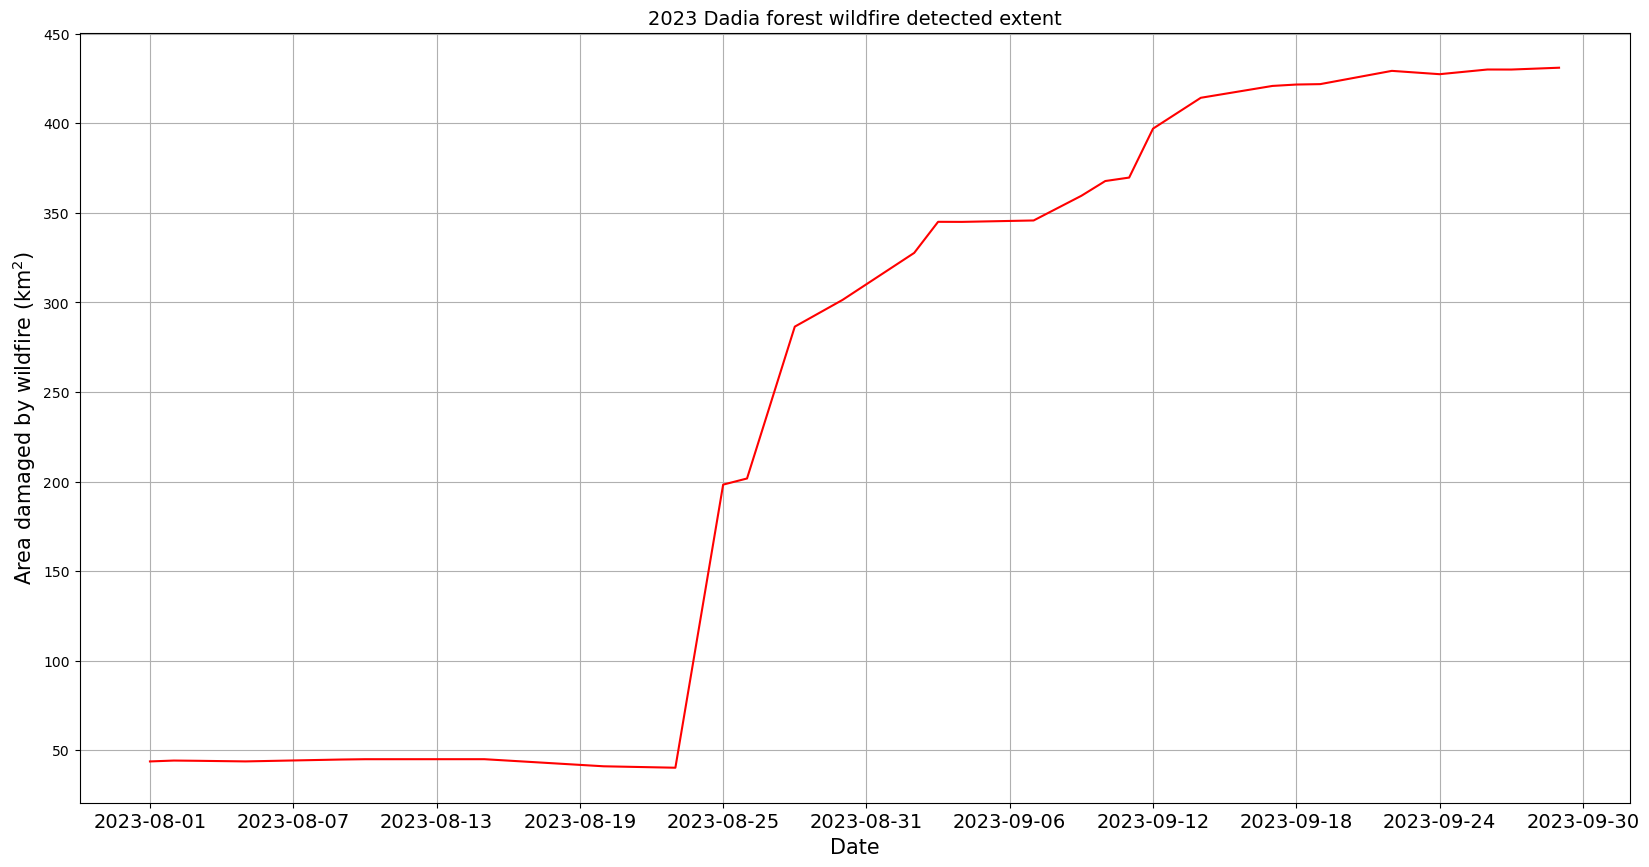

In [15]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ax.plot([datetime.strptime(i, '%Y-%m-%d') for i in refined_granules.index], refined_granules['damage_area'], color='red')
# ax.grid()
# plt.ylabel('Area damaged by wildfire (km$^2$)', size=15)
# plt.xlabel('Date', size=15)
# plt.xticks([datetime(year=2023, month=8, day=1) + timedelta(days=6*i) for i in range(11)], size=14)
# plt.title('2023 Dadia forest wildfire detected extent', size=14) ;

In [ ]:
type(by_day)

In [ ]:
len(by_day)

---